### Version history
- V1: mask_rcnn_r50_fpn_3x_ft_lr001 best checkpoint (20 epochs)
- V2: mask_rcnn_r50_fpn_3x_ft_lr001 checkpoint at 10th epoch
- V3: cascade_rcnn_r50_fpn_3x_ft checkpoint at 10th epoch
- V4: cascade_rcnn_r50_fpn_3x_ft checkpoint at 8th epoch
- V5: mask_rcnn_r50_fpn_3x_ft_lr001 10th checkpoint with TTA (TTA didn't work)
- V8: mask_rcnn_r50_fpn_3x pseudo labeling + fine tuning (lr 0.0005)
- V9: mask_rcnn_r50_fpn_3x pseudo labeling
- V10: mask_rcnn_r50_fpn_3x pseudo labeling + fine tuning with all train data (lr 0.001) / epoch 8
- V11: mask_rcnn_r50_fpn_3x pseudo labeling with all train data (trained all together, lr 0.001)
- V12: mask_rcnn_r50_fpn_3x from model_3029 / pseudo labeling with 95% train data / best checkpoint
- V13: mask_rcnn_r50_fpn_3x from model_3029 / pseudo labeling with 95% train data / final checkpoint
- V14: cascade_rcnn_r50_fpn_3x from model_3029 / pseudo labeling with 95% train data / best checkpoint
- V15: mask_rcnn_r50_fpn_3x pseudo labeling + fine tuning with all train data (lr 0.001) / final checkpoint (epoch 10)
- V16: mask_rcnn_r50_fpn_3x from model_3029 / pseudo labeling with all train data / final checkpoint (epoch 20)

### Installing detectron2 library

In [ ]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
import torch

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [3]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')

In [4]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [5]:
ids, masks=[],[]
test_names = (dataDir/'test').ls()

### Initiate the model

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 

cfg.MODEL.WEIGHTS = "../input/mask-rcnn-r50-fpn-3x-ft-lr001/rcnn_3029_pseudo_with_trainAll_final.pth"
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.18, .38, .58]
MIN_PIXELS = [75, 150, 75]

### Checking the sample output

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


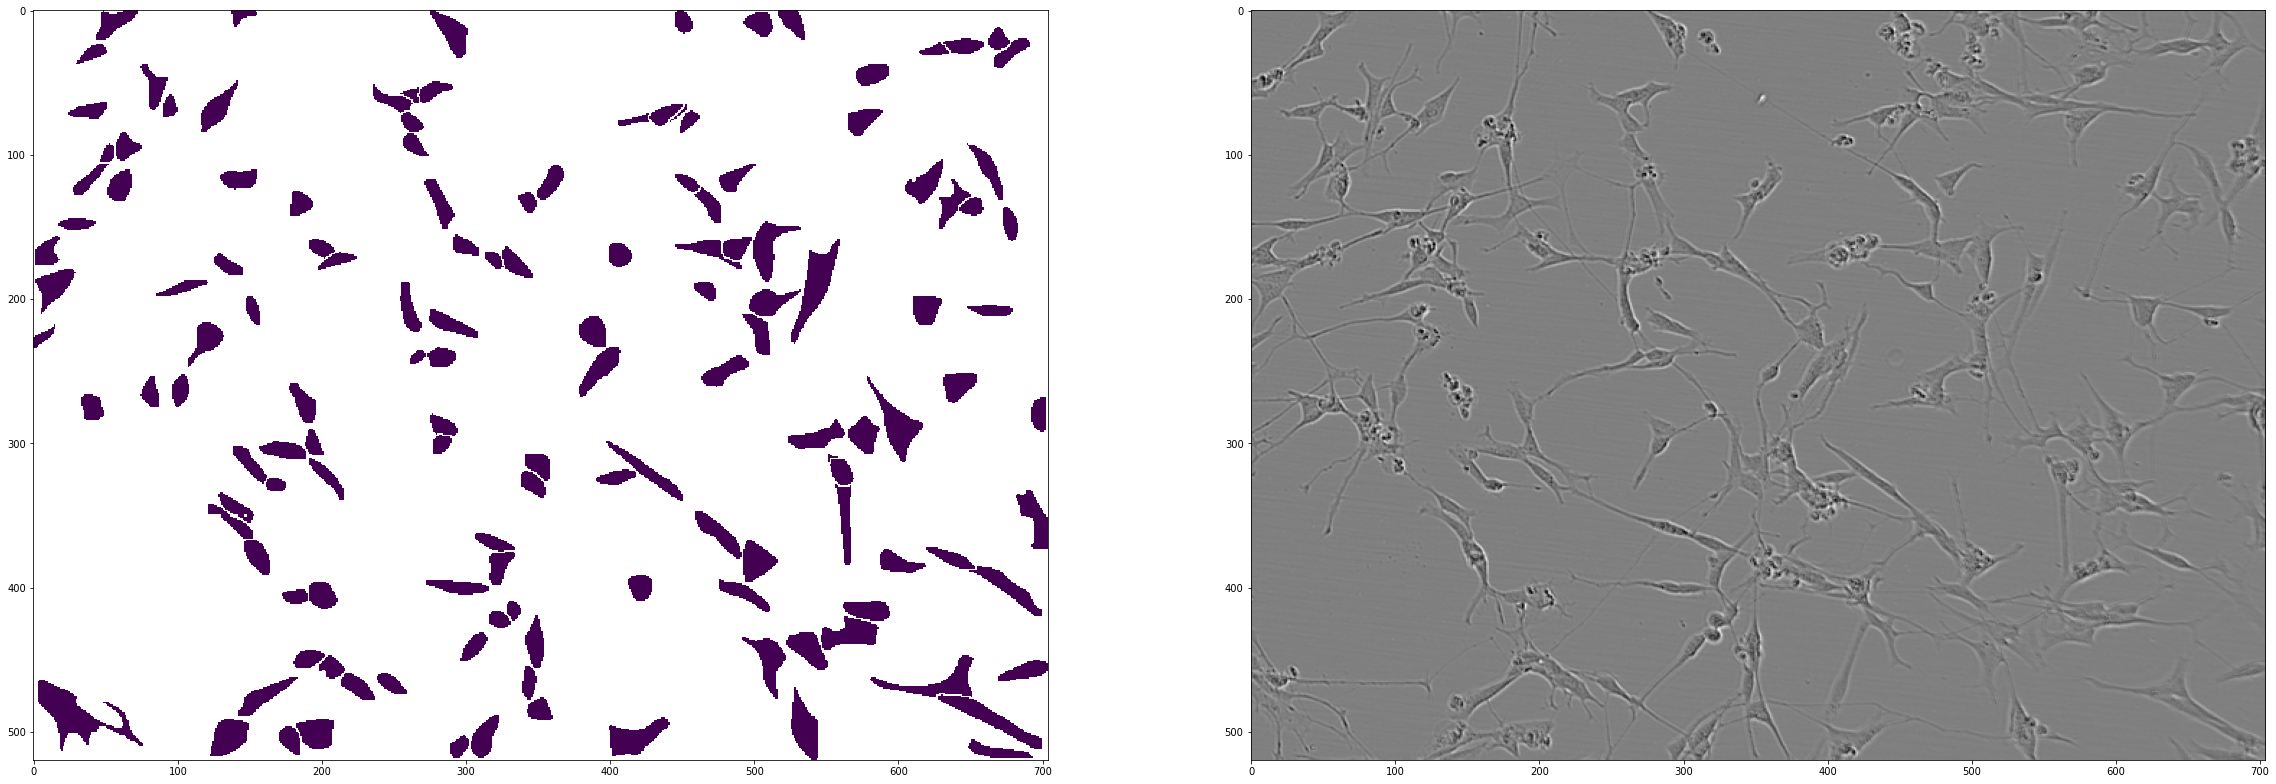

In [7]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

### Generate masks of test files for submission

In [8]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [9]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,353707 2 354409 5 355112 7 355814 10 356517 11...
1,7ae19de7bc2a,178194 4 178897 5 179600 6 180304 6 181007 7 1...
2,7ae19de7bc2a,140003 17 140707 20 141411 21 142115 21 142819...
3,7ae19de7bc2a,224917 4 225620 8 226323 11 227027 12 227731 1...
4,7ae19de7bc2a,40927 3 41630 5 42333 6 43037 7 43740 8 44444 ...
